<a href="https://colab.research.google.com/github/tharun-reddy/deep-learning-notebooks/blob/master/abstractive_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Mount G-drive for data

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

try:
  os.chdir('./gdrive/My Drive/')
except FileNotFoundError:
  print(os.getcwd())

In [0]:
import tensorflow_datasets as tfds

In [0]:
data, info = tfds.load('aeslc', shuffle_files=True, with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/aeslc/1.0.0.incomplete4IRMJT/aeslc-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/aeslc/1.0.0.incomplete4IRMJT/aeslc-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/aeslc/1.0.0.incomplete4IRMJT/aeslc-test.tfrecord


Dataset aeslc downloaded and prepared to /root/tensorflow_datasets/aeslc/1.0.0. Subsequent calls will reuse this data.


In [0]:
train = data['train']
test = data['test']
valid = data['validation']

In [0]:
for item in tfds.as_numpy(train.take(4)):
  print(item['email_body'])
  print(item['subject_line'])

{'email_body': b"Greg and Mark:  Attached is a draft of the very short story that will accompany your profiles in Enron Business.\n(PR management has approved.)\nThe purpose is simply to introduce you and quickly address the issue that's on everyone's mind, the stock price.\nPlease review your individual quotes and let me know if you have any revisions as soon as possible.\nThe quotes were extracted from your interviews with us a few weeks ago.\nIf I have not heard back from you by the end of the day tomorrow, I'll assume it's OK to print as is.\nThanks again for taking the time to meet with us.\nWarm regards and cheers,\n", 'subject_line': b'Enron Business Article'}
{'email_body': b"Please note the change in location for tomorrow's meeting.\nEB4102 is undergoing construction for several months.\nOps Committee Meeting \t\tFriday, 10/5 \t\t1:30 - 2:30 PM \t\tEB30C2 - OMA 3C1  Thanks.\n", 'subject_line': b'CMS/CRS Ops Committee Mtg, 10/5'}
{'email_body': b"John/John/Frank  As we are appr

In [0]:
import pandas as pd
import numpy as np

data = pd.read_csv('datasets/news_summary.csv', encoding='latin-1')
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [0]:
print(len(data))
data.dropna(axis=0, how='any', inplace=True)
print(len(data))

4514
4396


In [0]:
# remove unwanted columns

articles = data.ctext
summaries = data.headlines

In [0]:
print(articles[0]+'\n\n')
print(summaries[0])

The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Daman

## abstractive text summarization on news data

*   define encoder
*   define decoder
*   prediction function




In [0]:
# configuration

batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 4000

In [0]:
print(f'avg article length: {np.average([len(x.split()) for x in articles])}')
print(f'avg summary length: {np.average([len(x.split()) for x in summaries])}')

avg article length: 343.0677888989991
avg summary length: 9.300045495905369


In [0]:
#  model hyperparameters
VOCAB_SIZE = 10000
MAX_ARTICLE_LEN = 350
MAX_SUMMARY_LEN = 10
EMBEDDING_DIM = 100

In [0]:
# data preparation

import re

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

non_stop_words = {'not', 'none', 'nothing', 'nowhere', 'never', 'cannot',
                  'cant', 'couldnt', 'except', 'hasnt', 'neither', 'no',
                  'nobody', 'nor', 'without'}

def clean_text(text, max_len):
  text = '<bos> ' + text + ' <eos>'
  # stop_words = stop_words.ENGLISH_STOP_WORDS - non_stop_words
  new_text = ''
  for word in text.split():
    new_text = ' '.join([new_text, contractions.get(word, word)])
    if len(new_text.split()) > max_len:
      break
  new_text = re.sub(r'\t|\n|\r', ' ', new_text)
  return new_text

In [0]:
articles = articles.apply(lambda x: clean_text(x, 350))
summaries = summaries.apply(lambda x: clean_text(x, 10))

In [0]:
print(articles[0]+'\n\n')
print(summaries[0])

 <bos> The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by th

## Plotting

In [0]:
from matplotlib import pyplot as plt

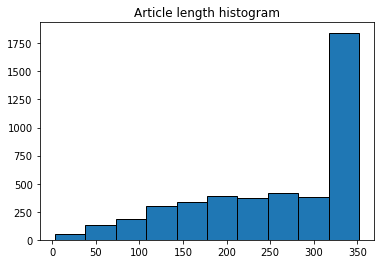

In [0]:
plt.hist([len(x.split()) for x in articles], bins=10, edgecolor='black')
plt.title('Article length histogram')
plt.show()

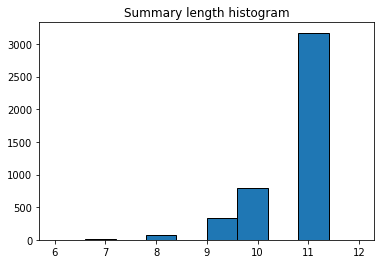

In [0]:
plt.hist([len(x.split()) for x in summaries], bins=10, edgecolor='black')
plt.title('Summary length histogram')
plt.show()

## Tokenize data

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(articles)

In [0]:
tokenizer.word_index['bos']

29

## Creating embedding matrix

In [0]:
path_to_glove_file = './library/glove/glove.6B.100d.txt'
embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_index[word] = coefs

print(f'{len(embeddings_index)} of word vectors')

KeyboardInterrupt: ignored

In [0]:
embeddings_index['word'].shape

In [0]:
embedding_matrix = np.zeros((tokenizer.num_words, EMBEDDING_DIM))
miss = 0
for word, index in tokenizer.word_index.items():
  if index >= VOCAB_SIZE:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
  else:
    miss += 1

print(f'total number of words not present in glove corpus: {miss}')

## Data preparation

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

articles_seq = tokenizer.texts_to_sequences(articles)
summaries_seq = tokenizer.texts_to_sequences(summaries)
articles_seq = pad_sequences(articles_seq, maxlen=MAX_ARTICLE_LEN, padding='post')
summaries_seq = pad_sequences(summaries_seq, maxlen=MAX_SUMMARY_LEN, padding='post')

In [0]:
# prepare data for teacher forcing kind of learning
def get_data(articles_seq, summaries_seq, batch_size):
  for num, batch in enumerate(range(len(articles_seq)//batch_size)):
    start = num * batch_size
    end = start + batch_size
    articles_batch = articles_seq[start:end]
    summaries_batch = summaries_seq[start:end]
    encoder_input_data = articles_batch
    decoder_input_data = summaries_batch
    decoder_target_data = np.zeros(shape=(batch_size, MAX_SUMMARY_LEN), dtype=int)
    for summary_ix, summary in enumerate(summaries_batch):
      for t, word_seq in enumerate(summary):
        if t > 0:
          decoder_target_data[summary_ix, t-1] = word_seq
    yield [encoder_input_data, decoder_input_data], decoder_target_data

In [0]:
x = next(get_data(articles_seq, summaries_seq, batch_size))

In [0]:
x[0][0].shape, x[0][1].shape, x[1].shape

In [0]:
# sanity check
x[0][1][0], x[1][0]

(array([  29, 1847, 9148,    4, 1437,  229,   45,    0,    0,    0],
       dtype=int32),
 array([1847, 9148,    4, 1437,  229,   45,    0,    0,    0,    0]))

## Training model

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

In [0]:
# define input sequence
encoder_inputs = Input(shape=(MAX_ARTICLE_LEN,))
# define embedding layer
encoder_embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                              input_length=MAX_ARTICLE_LEN,
                              weights=[embedding_matrix], trainable=False)
decoder_embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                              input_length=MAX_SUMMARY_LEN,
                              weights=[embedding_matrix], trainable=False)

# encoder setup
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embedding(encoder_inputs))
# ditch encoder_outputs & keep only states
encoder_states = [state_h, state_c]

# decoder setup
decoder_inputs = Input(shape=(MAX_SUMMARY_LEN,))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
# ditch the states and consider only outputs. we will use states
# at the time of inference
decoder_outputs, _, _ = decoder(decoder_embedding(decoder_inputs),
                                initial_state=encoder_states)
decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
decoder_output = decoder_dense(decoder_outputs)

# define model
# takes encoder_inputs & decoder_inputs -> decoder_target data
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_output)

In [0]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

filename = 'encoder_decoder_lstm_summarization.png'
plot_model(model, show_shapes=True, show_layer_names=True,
           to_file='./model_plots/'+filename)
Image('./model_plots/'+filename)

In [0]:
# instantiate an optimizer
optimizer = keras.optimizers.RMSprop(learning_rate=0.1)
# instantiate a loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [0]:
# run training
data = get_data(articles_seq, summaries_seq, batch_size=batch_size)
epochs = 50
for epoch in range(epochs):
  print(f'\nstart of epoch {epoch}')

  # iterate over batches of dataset
  for step, (x_batch_train, y_batch_train) in enumerate(get_data(articles_seq, summaries_seq, batch_size=batch_size)):

    # open a GradientTape to record the operations run during forward pass,
    # which enables autodifferentiation.
    with tf.GradientTape() as tape:

      # run the forward pass of the layer
      # the operations that the layer applies
      # to its inputs are going to be recorded on the GradientTape
      logits = model(x_batch_train, training=True)  # logits for this minibatch
      
      # compute the loss value for this minibatch
      loss = loss_fn(y_batch_train, logits)

    # use GradientTape to automatically retreive the gradients of the
    # trainable variables with respect to the loss.
    grads = tape.gradient(loss, model.trainable_weights)

    # run one step of gradient descent by updating the value of the
    # variable to minimize the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # log every 10 batches
    if step % 10 == 0:
      print(f'Training loss (for one batch) at step {step}: {loss:.2f}')
      print(f'Seen so far: {(step + 1)*batch_size} samples')

Training loss (for one batch) at step 30: 9.16
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 9.16
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 9.16
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 9.15
Seen so far: 3904 samples

start of epoch 9
Training loss (for one batch) at step 0: 9.15
Seen so far: 64 samples
Training loss (for one batch) at step 10: 9.17
Seen so far: 704 samples
Training loss (for one batch) at step 20: 9.15
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 9.16
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 9.16
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 9.16
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 9.15
Seen so far: 3904 samples

start of epoch 10
Training loss (for one batch) at step 0: 9.15
Seen so far: 64 samples


KeyboardInterrupt: ignored

## Inference